In [5]:
from entsoe import EntsoePandasClient
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit


In [6]:
with open(r'..\..\..\token.txt', 'r') as file:
    API_KEY = file.read()

# Los datos a descargar serán desde el 1 de enero de 2020 hasta el 31 de julio de 2025
client = EntsoePandasClient(api_key=API_KEY)
API_KEY

'4c6c5557-cee7-4ded-8578-24391034c06d'

In [7]:
def data_transformation(df):
    df.columns = df.columns.get_level_values(0)  
    df = df.astype(float)
    df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    df_diario = df.resample('D').sum()
    df_diario.dropna(axis=1, inplace=True)
    df_diario["Total_Renovable"] = df_diario[["Biomass", "Hydro Run-of-river and poundage", "Hydro Water Reservoir", 
                            "Other renewable", "Solar", "Wind Onshore", "Waste"]].sum(axis=1)

    df_diario["Total_Fossil"] = df_diario[["Fossil Gas", "Fossil Hard coal", "Fossil Oil"]].sum(axis=1)
    df_diario.drop(columns=["Hydro Pumped Storage", "Other"], inplace=True)
    df_time_series  = df_diario[['Total_Renovable', 'Total_Fossil', 'Nuclear', 'Solar', 'Fossil Gas']]
    return df_time_series

In [9]:
last_df = pd.read_csv(
    r'..\..\data\produccion_electrica_ES.csv',
    header=[0, 1],           
    index_col=0,             
    parse_dates=True,        
    low_memory=False)

In [10]:
last_time_series = data_transformation(last_df)
last_date= last_time_series.tail(1).index
last_date[0]

Timestamp('2025-07-15 00:00:00')

In [11]:
today_date = date.today()
today_date

datetime.date(2025, 8, 4)

In [12]:
start = pd.Timestamp(last_date[0], tz='UTC')
end = pd.Timestamp(today_date, tz='UTC')

In [13]:
new_data = data_transformation(client.query_generation(
    country_code='ES',
    start=start, end=end
))

In [14]:
new_data

,Total_Renovable,Total_Fossil,Nuclear,Solar,Fossil Gas
2025-07-15,1724548.0,621980.0,667764.0,1035612.0,617380.0
2025-07-16,1630888.0,766352.0,667180.0,1047012.0,762044.0
2025-07-17,1577536.0,833468.0,641000.0,975476.0,829616.0
2025-07-18,1755732.0,669516.0,664772.0,931516.0,665540.0
2025-07-19,1668664.0,420900.0,668524.0,817324.0,418728.0
2025-07-20,1624312.0,372488.0,659436.0,738316.0,370404.0
2025-07-21,1669248.0,520548.0,670468.0,1005300.0,517512.0
2025-07-22,1561768.0,606604.0,668752.0,965256.0,603232.0
2025-07-23,1557956.0,692760.0,668792.0,704036.0,689116.0
2025-07-24,1905252.0,462860.0,671888.0,747032.0,460284.0


In [15]:
def prediction_15(df, column):
    # Pipeline con MultiOutput para 15 predicciones
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('multi_model', MultiOutputRegressor(
            XGBRegressor(
                subsample=0.8,
                reg_lambda=0,
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                gamma=1,
                colsample_bytree=0.8
            )
        ))
    ])
    
    ventana = 30
    horizonte = 15

    serie = df[column].dropna()
    X_multi, Y_multi = [], []

    # Crear lags y etiquetas multisalida
    for i in range(len(serie) - ventana - horizonte + 1):
        X_multi.append(serie[i:i+ventana].values)
        Y_multi.append(serie[i+ventana:i+ventana+horizonte].values)

    X_multi = np.array(X_multi)
    Y_multi = np.array(Y_multi)

    # Entrenar el modelo con todos los datos disponibles
    pipe.fit(X_multi, Y_multi)

    # Última ventana conocida para hacer la predicción
    ultima_ventana = serie[-ventana:].values.reshape(1, -1)
    prediccion = pipe.predict(ultima_ventana)[0]

    # Crear fechas futuras (desde el día siguiente al último)
    fecha_inicio = serie.index[-1] + pd.Timedelta(days=1)
    fechas_futuras = pd.date_range(start=fecha_inicio, periods=horizonte, freq='D')

    # Crear Serie con las predicciones
    pred_series = pd.Series(prediccion, index=fechas_futuras, name='Predicción Solar')

    return pred_series


In [16]:
predictions = prediction_15(last_time_series, 'Solar')
predictions

2025-07-16    895227.5625
2025-07-17    902026.6875
2025-07-18    890754.9375
2025-07-19    861512.7500
2025-07-20    839354.5000
2025-07-21    867920.9375
2025-07-22    872463.4375
2025-07-23    859076.6250
2025-07-24    860684.8750
2025-07-25    890827.0625
2025-07-26    839108.0000
2025-07-27    843315.1875
2025-07-28    867443.4375
2025-07-29    841031.5000
2025-07-30    835299.9375
Freq: D, Name: Predicción Solar, dtype: float32

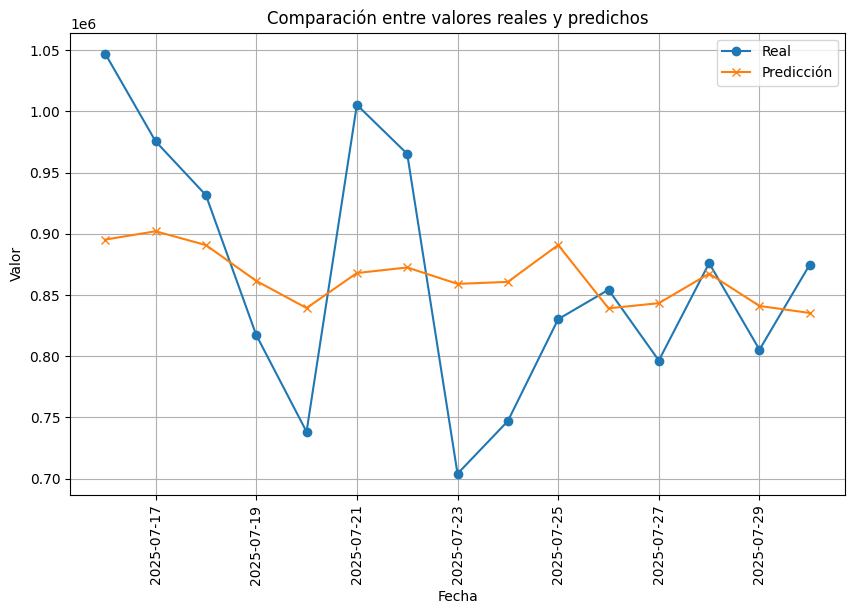

74432.90416666666
0.21523307730602836


In [17]:
# Convertir ambos índices a solo fecha
pred_fechas = predictions.index.normalize()
real_fechas = new_data.index.normalize()

# Filtrar los valores reales
valores_reales = new_data.loc[real_fechas.isin(pred_fechas), 'Solar']
valores_reales.index = pred_fechas[:len(valores_reales)]  # asegurar alineación

%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(valores_reales.index, valores_reales.values, label='Real', marker='o')
plt.plot(predictions.index.normalize(), predictions.values, label='Predicción', marker='x')
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Fecha')
plt.xticks(rotation=90)
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

print(mean_absolute_error(valores_reales, predictions))
print(r2_score(valores_reales, predictions))

In [ ]:
pred = pd.Series()

In [ ]:
def visualizar_futuro(last_time_series, new_data, column, predictions):
    df = pd.concat((last_time_series, new_data), axis=0)
    df = df.loc[df.index.year >= 2025, column]
    df = pd.concat((df, predictions))
    return df

In [ ]:
visualizar_futuro(last_time_series, new_data, 'Solar')

2025-01-01    316704.0
2025-01-02    380012.0
2025-01-03    295336.0
2025-01-04    271888.0
2025-01-05    150516.0
                ...   
2025-07-30    874876.0
2025-07-31    902896.0
2025-08-01    845172.0
2025-08-02    836996.0
2025-08-03    774660.0
Name: Solar, Length: 216, dtype: float64

In [27]:
# Últimos datos reales
ultimos_datos = visualizar_futuro(last_time_series, new_data, 'Solar', )
ultimos_datos.index = pd.to_datetime(ultimos_datos.index)

# Generar fechas futuras
fecha_inicio = ultimos_datos.index[-1] + pd.Timedelta(days=1)
fechas_futuras = pd.date_range(start=fecha_inicio, periods=15)

# Base para predicción: media móvil de los últimos días
base = ultimos_datos.rolling(window=3, min_periods=1).mean().iloc[-1]

# Crear datos con tendencia decreciente leve + ruido aleatorio
np.random.seed(42)  # Para reproducibilidad
predicciones_sinteticas = base - np.linspace(0, 100000, 15) + np.random.normal(0, 15000, size=15)

# Asegurar que los valores no sean negativos
predicciones_sinteticas = np.clip(predicciones_sinteticas, a_min=0, a_max=None)

# Crear serie de predicciones
serie_pred = pd.Series(data=predicciones_sinteticas, index=fechas_futuras)
serie_pred


2025-08-04    826393.378962
2025-08-05    809725.845006
2025-08-06    814372.280452
2025-08-07    820359.543084
2025-08-08    786858.937474
2025-08-09    779716.326598
2025-08-10    799773.716042
2025-08-11    780454.187604
2025-08-12    754757.693735
2025-08-13    762795.353035
2025-08-14    740562.829846
2025-08-15    733385.291792
2025-08-16    736857.815026
2025-08-17    697386.320140
2025-08-18    693068.899179
Freq: D, dtype: float64

In [33]:
import pandas as pd
import plotly.express as px

def visualizar_futuro2(last_time_series, new_data, column, predictions):
    """
    Visualiza datos históricos y predicciones futuras con Plotly en Streamlit.
    """
    # Combinar datos pasados
    df_pasado = pd.concat([last_time_series, new_data])
    df_pasado = df_pasado[[column]].copy()
    df_pasado = df_pasado.loc[df_pasado.index.year >= 2025]

    # Preparar DataFrame para datos históricos
    df_hist = df_pasado.reset_index().rename(columns={'index': 'Fecha', column: 'Valor'})
    df_hist['Tipo'] = 'Histórico'

    # Asegurar que predictions es una Serie con índice datetime
    df_pred = pd.DataFrame({
        'Fecha': predictions.index,
        'Valor': predictions.values,
        'Tipo': 'Predicción'
    })

    # Concatenar ambos DataFrames
    df_plot = pd.concat([df_hist, df_pred], ignore_index=True)

    # Forzar 'Tipo' como categoría para que Plotly lo interprete correctamente
    df_plot['Tipo'] = df_plot['Tipo'].astype('category')

    # Crear gráfico con Plotly Express
    fig = px.line(df_plot, x='Fecha', y='Valor', color='Tipo', markers=True,
                  title=f'Evolución y predicción de {column}')

    fig.update_layout(
        xaxis_title='Fecha',
        yaxis_title=column,
        xaxis_tickangle=-45,
        template='plotly_white'
    )

    return fig


In [34]:
fig = visualizar_futuro2(last_time_series, new_data, 'Solar', serie_pred)
fig